## Lógica Computacional: 21/22## 
---
##Trabalho 2## 

$Grupo$ $7$ 

*   David José de Sousa Machado (A91665)
*   Ivo Miguel Gomes Lima (A90214)
---
#Inicialização

Para a resolução destes exercícios usamos a biblioteca [Python Z3Py](https://ericpony.github.io/z3py-tutorial/guide-examples.htm) que criou uma interface para o Z3. Esta biblioteca foi instalada com o commando `!pip install z3-solver`.

Assim como a biblioteca [OR-Tools](https://developers.google.com/optimization) que criou uma interface para o SCIP. Esta biblioteca foi instalada com o commando `!pip install ortools`.

In [ ]:
!pip install z3-solver
!pip install ortools

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'


In [ ]:
import networkx as nx
import random
from z3 import *
import numpy as np
import math
from ortools.linear_solver import pywraplp

# Problema 1:
1. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . 
    >  O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.
    1. Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$  cujos destinos são distintos entre si do nodo origem.
    2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.
  
#Implementação

In [ ]:
def make_cycle(g, v):
  for i in range(len(v)):
    if v[i-1] == v[i]:
      break
    g.add_edge(v[i-1], v[i])


def gera(N):
  fatores = [fac for fac in range(1, N+1) if N % fac == 0]
  vertices = list(range(N))
  grafo = nx.DiGraph()
  grafo.add_nodes_from(vertices)

  scramble = random.sample(vertices, N)

  length = N
  cycles = []
  while length > 0:
    start = N-length
    n = random.randint(1, length)
    cycles.append(scramble[start : start + n])
    length -= n

  print(cycles)

  link = []
  for i in range(len(cycles)):
    test = cycles[i]+link
    print(test)
    make_cycle(grafo, cycles[i]+link)
    link = random.sample(cycles[i], 1)

  print(grafo.edges, len(grafo.edges))

  for node in grafo.nodes:
    if grafo.out_degree(node) < 3:
      n_new_nodes = random.randint(0, 3 - grafo.out_degree(node))
      if n_new_nodes:
        for dest in random.sample([v for v in vertices if v != node], n_new_nodes):
          grafo.add_edge(node, dest)


  print(grafo.edges)

  return grafo

[[0, 5, 4, 3, 7, 13], [9, 12], [14, 10, 6, 11, 8, 2, 1]]
[0, 5, 4, 3, 7, 13]
[9, 12, 0]
[14, 10, 6, 11, 8, 2, 1, 12]
[(0, 5), (0, 9), (1, 12), (2, 1), (3, 7), (4, 3), (5, 4), (6, 11), (7, 13), (8, 2), (9, 12), (10, 6), (11, 8), (12, 0), (12, 14), (13, 0), (14, 10)] 17
[(0, 5), (0, 9), (0, 13), (1, 12), (1, 14), (2, 1), (2, 8), (2, 4), (3, 7), (3, 14), (3, 10), (4, 3), (4, 1), (5, 4), (5, 10), (5, 12), (6, 11), (6, 12), (6, 4), (7, 13), (8, 2), (8, 10), (9, 12), (9, 4), (10, 6), (10, 13), (10, 5), (11, 8), (12, 0), (12, 14), (13, 0), (14, 10), (14, 8), (14, 5)]
34


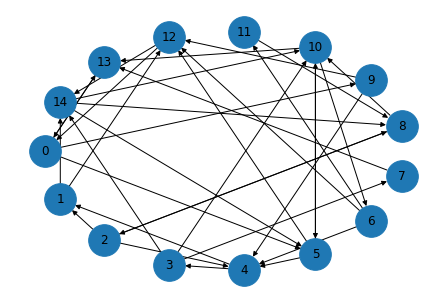

In [ ]:
N = 15
grafo = gera(N)
print(len(grafo.edges))
nx.draw(grafo, with_labels=True, node_size=1000, pos = nx.shell_layout(grafo))

**Análise do problema**

É dado um grafo de *input* $G = (V, E)$ conectado e orientado.

Queremos determinar um subgrafo $G' = (V, E')$ de $G$, minimizando $E'$ mas garantindo que o grafo permanece ligado.

Tanto o grafo original como o seu subgrafo podem ser representados por um dicionário de tuplos de arestas denominadas $s$ e $t$, sendo que estes elementos $D_{s,t} \in [0, 1]$ e representam a existência de uma ligacão de $n_s$ a $n_t$.

1.   Logo atráves da afirmação acima concluímos que uma aresta pertencente a $G$ também deve pertencer a $G'$:

$$ \forall_{ (n_s, n_t)\ \in\ G}, \quad 0 \le D_{s,t} \le 1 $$

Para cada par de vértices $(n_s, n_t) \in G$ existe um conjunto de caminhos sem loops tal que $P = \{Paths\}$ que ligam $n_s$ a $n_t$. Para fazer esse calculo usamos a função [`all_simple_paths`](https://networkx.org/documentation/networkx-1.9/reference/generated/networkx.algorithms.simple_paths.all_simple_paths.html).

2.   Portanto para um dado caminho $Paths$ existir, temos que:

$$\prod_{( n_x, n_y )\ \in\ Paths} D_{x, y} = 1 $$

3.   Para garantir a existência desse caminho $Paths \in P$, temos de assegurar que a soma das multiplicações dos dados caminhos são superiores ou iguais a 1, pois se isso nao acontecer o caminho é inacessível e portanto não é válido:

$$ \forall_{( n_s, n_t )\ \in\ G}, \sum_{Paths\ \in\ P} \left( \prod_{( n_x, n_y ) \in Paths} D_{x, y} \right) \ge 1 $$

4.   Devemos então tentar minimizar este número de $G'$:

$$ Minimize\ (\sum_{s=0}\ \sum_{t=0} D_{s,t}) $$


**Outra Forma**

Nesta segunda versão acrescentamos uma condição que limita inferiormente e superiormente os valores com o auxilio da função [`simple_cycles`](https://networkx.org/documentation/networkx-2.3/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html)

As arestas removidas foram [(0, 5), (0, 13), (1, 14), (2, 1), (2, 8), (3, 14), (3, 10), (5, 4), (5, 12), (6, 12), (6, 4), (8, 10), (9, 12), (10, 13), (10, 5), (12, 0), (14, 10), (14, 8)]
O número de arestas removidas foi 18


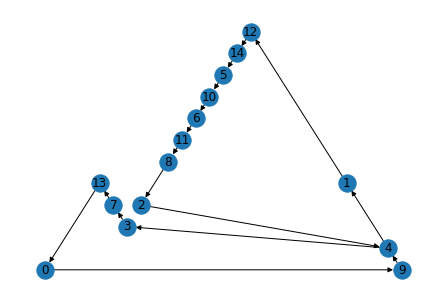

In [ ]:
def path_edges(p):
  return [(p[i],p[i+1]) for i in range(len(p)-1)]

def remove_paths(grafo):
    N = len(list(grafo.nodes()))
    sol = Optimize()
    d = {}

    for s,t in grafo.edges:
        d[(s,t)] = Int(f"d({s},{t})")
        sol.add(0 <= d[(s,t)], d[(s,t)] <= 1)
    
    # Deve haver sempre um caminho entre cada par de nodos
    for s in grafo.nodes:
        for t in grafo.nodes:
            if(s == t): continue
            l = []
            for p in nx.all_simple_paths(grafo, s, t):
                paths = path_edges(p)
                l.append(Product([d[(x,y)] for x,y in paths]))
            sol.add(Sum(l) >= 1)
    
    # Deve haver pelo menos V arestas no grafo
    sol.add(sum(d.values()) >= grafo.number_of_nodes())

    # A solução tem no máximo V + (V-len(maior_ciclo))*2
    ciclos = [len(ciclo) for ciclo in nx.simple_cycles(grafo)] # buscar o ciclo mais longo
    ciclo = max(ciclos)
    sol.add(sum(d.values()) <= grafo.number_of_nodes() + (grafo.number_of_nodes() - ciclo) * 2)

    # Minimizar o número de arestas
    sol.minimize(sum(d.values()))

    # Verificar a satisfabilidade
    if sol.check() == sat:
        m = sol.model()
        rem_edges = [(i,j) for i,j in grafo.edges if m[d[i,j]]==0]
        print(f"As arestas removidas foram {rem_edges}")
        print("O número de arestas removidas foi", len(rem_edges))
        r = nx.DiGraph.copy(grafo)
        r.remove_edges_from(rem_edges)
    else:
        r = None
        print("Sem solução")
    return r


graph=remove_paths(grafo)
nx.draw(graph, with_labels=True, pos = nx.planar_layout(graph))

**Outra Tentativa**

Também tentamos fazer uma implementação através da função `set_cover` que dada a matriz de incidência determine quais os conjuntos que pertencem à cobertura mínima.

*   O objectivo é minimizar  o somatório de todos os $x_j$, onde cada elemento de  A  tem que  pertencer a pelo menos um conjunto da cobertura.

$$ Minimize\ (\forall i \in A \cdot \sum_{j = 0}^{N-1} A_{i,j} \times x_j \geq 1) $$

Mas acabou por não funcionar como esperavamos...

[0, 15, 14, 2, 18, 7, 11, 1]
[0, 5, 4, 17, 19, 16, 15, 9, 6, 3, 8, 13, 12, 10]
22


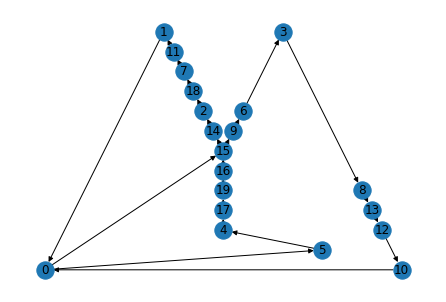

In [ ]:
ciclos = list(nx.simple_cycles(grafo))
A = np.zeros((len(ciclos), N))

for ciclo in range(len(ciclos)):
    for nodo in range(N):
        A[ciclo, nodo] = int(nodo in ciclos[ciclo])

def set_cover(A):
    s = Optimize()
    sets = len(A)
    elems = len(A[0])

    x = {}
    for j in range(sets):
        x[j] = Int(str(j))
        s.add(0 <= x[j], x[j] <= 1)

    # Todos os nodos têm de estar presentes
    for i in range(elems):
        s.add(sum(A[j][i]*x[j] for j in range(sets)) >= 1)
  
    soma = sum(A[j][i]*x[j] for j in range(sets) for i in range(elems))
    
    s.add(soma == elems+sum(x.values()))
    # Minimizar as vezes que um nodo está presente
    s.minimize(soma)

    if s.check() == sat:
        m = s.model()
        return [j for j in range(sets) if m[x[j]] == 1]
    else:
        print('No optimal solution')

show = nx.DiGraph()
for n in set_cover(A):
    print(ciclos[n])
    show.add_nodes_from(ciclos[n])
    make_cycle(show, ciclos[n])

print(len(show.edges))
nx.draw(show, with_labels=True, pos = nx.planar_layout(show))

# Problema 2:
2. Considere-se um circuito booleano $\,\mathcal{C}\,$ com $\,n\,$ “wires” de “input” e um único “wire” de output.
    - O circuito é descrito num bi-grafo com uma classe de nodos representando “gates” e a segunda classe representando “wires” . 
    - Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo val contém uma variável SCIP; para as “gates” o campo val contém uma marca bo conjunto and, or, xor e not, que indica o tipo de “gate”. 
    - Com exceção de not, que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.
    - No grafo os arcos com origem numa determinada “gate” têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.
    - A semântica das várias “gates” é expressa em relações na Aritmética Linear Inteira, tal como está descrita em +Capítulo 2: Programação com Restrições (#LIA)

    1. Escreva um programa que, a partir do número, $n$ de “inputs” e de um parâmetro positivo $\gamma \ll 1$ como argumentos, gere aleatoriamente circuitos com “gates” or, and e not em que o número de and's é $\gamma \ast$ (número total de nodos).
    2. Escreva um programa Python que leia um circuito arbitrário descrito pelo bi-grafo anterior e formule as restrições (em Programação Inteira) que descrevem as várias “gates” do circuito.
    3. Usando os dois programas anteriores e o sistema SCIP, 
        1. Escreva um programa que determine um vetor de “inputs” $x \in \{0,1\}^n$ aceite pelo circuito (i.e. o respetivo output é $1$).
        2. Determine o vetor $x' \neq x$ , também aceite pelo circuito, que está mais próximo de $x$. 
        

**Gerar o circuito**

De forma a garantirmos que $and = \gamma \times $(número total de nodos) é uma condição válida, criamos uma função chamada `calc_and` que dado o valor de n e $\gamma$ acumula os resultados de $n \times \gamma \times 2 $ enquanto $n > 1$ o que resulta no numero de nós do grafo. 

> Nota: Esperamos que $\gamma$ seja menor que 0.5
#Implementação

In [ ]:
def desenha(circ):
    labels = {n : circ.nodes[n]['node_type'] for n in circ}
    dic = {
        "INPUT": "#FFEF78",
        "WIRE": "#B1FFFD",
        "AND": "#9C19E0",
        "NOT": "#FF5DA2",
        "OR": "#1597BB"
    }
    colors = [dic[circ.nodes[n]['node_type']] for n in circ]
    nx.draw(circ, with_labels=True, labels=labels, node_size = 800, node_color=colors, font_weight='bold', pos = nx.spring_layout(circ)) 

def calc_and(n, gamma):
    n *= gamma * 2
    acc = n

    while n > 1:
        n *= gamma * 2
        acc += n
  
    return math.floor(acc) if math.floor(acc) % 2 == 0 else math.floor(acc) + 1

def gera_circuito(n, gamma):
    ors = random.randint(1, n) * 2
    nots = random.randint(1, n) * 2
    ands = calc_and(n+ors+nots, gamma)
    circuito = nx.DiGraph()
    gates = {
        "AND": (n, n+ands),
        "OR": (n+ands, n+ands+ors),
        "NOT": (n+ands+ors, n+ands+ors+nots)
    }

    # adding inputs
    for i in range(n):
        circuito.add_node(i, node_type="INPUT")
    # adding gates
    for n_type, (start, end) in gates.items():
        for i in range(start, end, 2):
            circuito.add_node(i, node_type=n_type)
            circuito.add_node(i+1, node_type="WIRE", val=None)
            # ligar gate ao wire
            circuito.add_edge(i, i+1)
    
    output = random.sample(list(range(gates["AND"][0]+1, gates["OR"][1], 2)), 1)[0]
    wires = {el for el in range(gates["AND"][0]+1, gates["NOT"][1], 2) if el != output}
    wires.union(set(range(0, gates["AND"][0])))

    vis = set()
    stack = [output]
    while stack and wires:
        el = stack.pop()

        if el in vis: continue
        vis.add(el)

        inputs = random.sample(wires, 1) if circuito.nodes[el]["node_type"] == "NOT" else random.sample(wires, random.randint(1, len(wires)))
        
        for input in inputs:
            circuito.add_edge(input, el-1)
            stack.append(input)
            wires.remove(input)
    

    disconnected = [el for el in range(gates["AND"][0], gates["NOT"][1], 2) if circuito.in_degree(el) == 0]
    for disc in disconnected:
        inp = random.randint(0, n-1) 
        circuito.add_edge(inp, disc)

    # ligar inputs a pelo menos uma gate
    for i in range(n):
        if circuito.out_degree(i) == 0:
            circuito.add_edge(i, output-1)
    
    gates["OUTPUT"] = output

    return gates, circuito

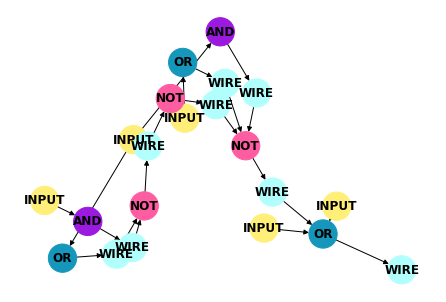

In [ ]:
n, g = 5, 0.1
gates, circ = gera_circuito(n, g)
desenha(circ)

**Análise do Problema**

Tendo em conta o material fornecido pelo docente da disciplina [aqui](https://paper.dropbox.com/doc/Capitulo-2-Programacao-com-Restricoes-x8IebJsYYIvi0KYezj4Uu#:uid=140371385393078716549042&h2=Restri%C3%A7%C3%B5es-booleanas) podemos formalizar o seguinte conjunto de restrições:

1.   Tomando $X$ como a lista que contém todos os nodos ligados, para o caso da *gate* tipo $And$ devemos levar em conta o menor valor de *input*. Ou seja:

$$\forall_{n \in X} \ X_n \geq X_i \cdot \sum_{i \in X} X_n < X_i + len_{inputs}(X) $$

2.   Para um *gate* $Or$ temos de ter em atenção o maior valor de *input* pois o *output* depende dele. Isto é:
$$\forall_{n \in X} \ X_n \leq X_i \cdot \sum_{i \in X} X_n \geq X_i$$

3.   No tipo $Not$ a lista que contém todos os nodos ligados apenas possui 1 elemento, isto significa que se $X_n = 0 \rightarrow X_i = 1$ e vice-versa.
$$ X_n + Xi = 1 $$

In [ ]:
def make_solver(G, gates):
    solver = pywraplp.Solver.CreateSolver("SCIP")
    wires = [n for n in G if G.nodes[n]["node_type"] == "WIRE"]
    X = {input: solver.BoolVar(str(input)) for input in G if G.nodes[input]["node_type"] == "INPUT" or G.nodes[input]["node_type"] == "WIRE"}


    for n in wires:
        inputs = [s for (s,t) in G.in_edges(n-1)]

        if G.nodes[n-1]["node_type"] == "AND":
            solver.Add(sum(X[i] for i in inputs) <= X[n]+len(inputs) - 1)
            for i in inputs:
                solver.Add(X[i] >= X[n])
        elif G.nodes[n-1]["node_type"] == "OR":
            solver.Add(X[n] <= sum(X[i] for i in inputs))
            for i in inputs:
                solver.Add(X[i] <= X[n])
        elif G.nodes[n-1]["node_type"] == "NOT":
            solver.Add(X[n] + X[inputs[0]] == 1)
    
    return solver, X

**Resolver o circuito**

In [ ]:
def solve_circ(G, gates):
    solver, X = make_solver(G, gates)

    solver.Add(X[gates['OUTPUT']] == 1)

    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        for n in X:
            G.nodes[n]['val'] = round(X[n].solution_value())
        
        res1 = [round(X[i].solution_value()) for i in range(gates["AND"][0])]
        if solver.NextSolution():
            res2 = [round(X[i].solution_value()) for i in range(gates["AND"][0])]
            return res1,res2
        else:
            return res1
    else:
        print("no solution found")

In [ ]:
solve_circ(circ, gates)

[1, 0, 0, 1, 1]